In [1]:
import os
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from sklearn.preprocessing import MinMaxScaler

In [2]:
os.chdir('../..')

## 1. SST

In [3]:
perturbation_df_dict = pickle.load(open('data/processed/perturbation_df_dict_SST_BERT.pickle', 'rb'))

In [4]:
perturbation_df_dict.keys()

dict_keys(['strip_punct', 'remove_commas', 'remove_all_punct', 'change_first_name', 'change_last_name', 'change_location', 'add_typo', 'switch_gender', 'swap_adj'])

## Generate table heatmap


In [5]:
results_dict = {}

k=5
  
for perturbation, df in perturbation_df_dict.items():
    if df is None:
        continue

    del df['spearman']
        
    df['top_k_idx_orig'] = df.apply(lambda x: set(np.argsort(-np.array(x[f'shap_orig_values']))[:k]), axis=1)
    df['top_k_idx_perturb'] = df.apply(lambda x: set(np.argsort(-x[f'shap_{perturbation}_values'])[:k]), axis=1)

    df['k_intersection'] = df.apply(lambda x: len(x['top_k_idx_orig'].intersection(x['top_k_idx_perturb'])) / k, axis=1)
    
    df['spearman'] = df.apply(lambda x: spearmanr(x['shap_orig_values'], x[f'shap_{perturbation}_values'])[0], axis=1)
    
    results_dict[perturbation] = {
        'top_k_mean': df['k_intersection'].mean(),
        'top_k_std': df['k_intersection'].std(),
        'spearman_mean': df['spearman'].mean(),
        'spearman_std': df['spearman'].std()
    }

In [6]:
PERTURBATION_FULL_FORM_DICT = {
    'strip_punct': 'Strip end punctuation',
    'remove_commas': 'Remove commas',
    'remove_all_punct': 'Remove all punctuation',
    'change_first_name': 'Change first name',
    'change_last_name': 'Change last name',
    'change_location': 'Change location',
    'add_typo': 'Add typo',
    'switch_gender': 'Switch gender',
    'swap_adj': 'Swap adjective'
}

In [7]:
results_df = pd.DataFrame(results_dict).T
results_df.rename(index=PERTURBATION_FULL_FORM_DICT, columns={'top_k_mean': 'Mean top-5 intersection (± sd)', 'spearman_mean': "Mean Spearman (± sd)"}, inplace=True)
results_df

,Mean top-5 intersection (± sd),top_k_std,Mean Spearman (± sd),spearman_std
Strip end punctuation,0.826997,0.271355,0.830875,0.225575
Remove commas,0.550549,0.354879,0.582265,0.335917
Remove all punctuation,0.684167,0.321736,0.613514,0.361627
Change first name,0.809756,0.316073,0.902063,0.164488
Change last name,0.860870,0.291920,0.900805,0.151217
Change location,0.880000,0.109545,0.866566,0.138374
Add typo,0.904762,0.162715,0.832741,0.241640
Switch gender,0.921951,0.218532,0.960039,0.056319
Swap adjective,0.785714,0.354872,0.874816,0.154373


In [8]:
# Create string labels with mean and std
for i in range(10):
    results_df[f'label_top_k'] = np.round(results_df[f'Mean top-5 intersection (± sd)'], 2).astype(str) + ' (±' + np.round(results_df[f'top_k_std'], 2).astype(str) + ')'
    results_df[f'label_spearman'] = np.round(results_df[f'Mean Spearman (± sd)'], 2).astype(str) + ' (±' + np.round(results_df[f'spearman_std'], 2).astype(str) + ')'

In [9]:
results_df

,Mean top-5 intersection (± sd),top_k_std,Mean Spearman (± sd),spearman_std,label_top_k,label_spearman
Strip end punctuation,0.826997,0.271355,0.830875,0.225575,0.83 (±0.27),0.83 (±0.23)
Remove commas,0.550549,0.354879,0.582265,0.335917,0.55 (±0.35),0.58 (±0.34)
Remove all punctuation,0.684167,0.321736,0.613514,0.361627,0.68 (±0.32),0.61 (±0.36)
Change first name,0.809756,0.316073,0.902063,0.164488,0.81 (±0.32),0.9 (±0.16)
Change last name,0.860870,0.291920,0.900805,0.151217,0.86 (±0.29),0.9 (±0.15)
Change location,0.880000,0.109545,0.866566,0.138374,0.88 (±0.11),0.87 (±0.14)
Add typo,0.904762,0.162715,0.832741,0.241640,0.9 (±0.16),0.83 (±0.24)
Switch gender,0.921951,0.218532,0.960039,0.056319,0.92 (±0.22),0.96 (±0.06)
Swap adjective,0.785714,0.354872,0.874816,0.154373,0.79 (±0.35),0.87 (±0.15)


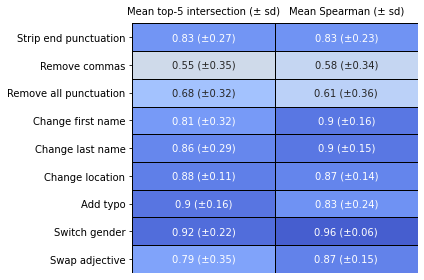

In [10]:
sns.heatmap(
    results_df.drop(['top_k_std', 'spearman_std', 'label_top_k', 'label_spearman'], axis=1), 
    cbar=False, 
    vmin=0,
    vmax=1,
    annot=results_df[['label_top_k', 'label_spearman']].values,
    fmt='',
    cmap='coolwarm_r', 
    linewidths=1, 
    linecolor='black'
)
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom=False, bottom=False, top=False, labeltop=True)
plt.tight_layout()
plt.show()

### Explore individual cases

In [11]:
def plot_examples(perturbation, num_examples, return_df=False):
    
    perturbation_df = perturbation_df_dict[perturbation].copy()
    
    for _ in range(num_examples):
        idx = np.random.choice(len(perturbation_df))
        example = perturbation_df.iloc[idx]
        
        example_df = pd.DataFrame({
            'shap_orig_tokens': example['shap_orig_tokens'],
            'shap_orig_values': example['shap_orig_values'],
            f'shap_{perturbation}_tokens': example[f'shap_{perturbation}_tokens'],
            f'shap_{perturbation}_values': example[f'shap_{perturbation}_values']
        })
        
        # MinMax scale to get scores within 0,1
        example_df['shap_orig_values'] = MinMaxScaler().fit_transform(example_df['shap_orig_values'].values.reshape(-1, 1)).flatten()
        example_df[f'shap_{perturbation}_values'] = MinMaxScaler().fit_transform(example_df[f'shap_{perturbation}_values'].values.reshape(-1, 1)).flatten()
        
        # Sort by SHAP scores before perturbation
        example_df.sort_values('shap_orig_values', ascending=False, inplace=True)
        example_df.reset_index(drop=True, inplace=True)
        
        print(f"Original sentence: {example['sentence']}")
        print(f"Model prediction: {example['orig_prediction']}")
        print(f"Top-5 intersection: {example['k_intersection']}")
        print(f"Spearman: {np.round(example['spearman'], 2)}")
        
        plt.figure(figsize=(10, 4))
        ax = sns.barplot(x=example_df.index, y='shap_orig_values', data=example_df, ci=None, color='blue', alpha=0.3, label='Original')
        ax = sns.barplot(x=example_df.index, y=f'shap_{perturbation}_values', data=example_df, ci=None, color='red', alpha=0.3, label=PERTURBATION_FULL_FORM_DICT[perturbation])
        ax.set_xticklabels(example_df['shap_orig_tokens'])
        ax.set_xlabel('Token')
        ax.set_ylabel('Normalised SHAP score')
        plt.xticks(rotation=90)
        plt.legend()
        plt.show()
        
        if return_df:
            return example_df

In [12]:
perturbation_df_dict.keys()

dict_keys(['strip_punct', 'remove_commas', 'remove_all_punct', 'change_first_name', 'change_last_name', 'change_location', 'add_typo', 'switch_gender', 'swap_adj'])


strip_punct

Original sentence: Broomfield turns his distinctive ` blundering ' style into something that could really help clear up the case .
Model prediction: 3
Top-5 intersection: 0.8
Spearman: 0.58


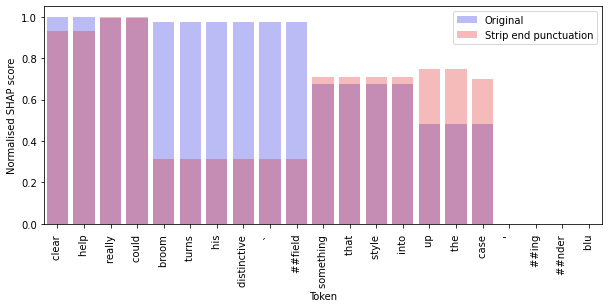

Original sentence: No sophomore slump for director Sam Mendes , who segues from Oscar winner to Oscar-winning potential with a smooth sleight of hand .
Model prediction: 3
Top-5 intersection: 1.0
Spearman: 0.59


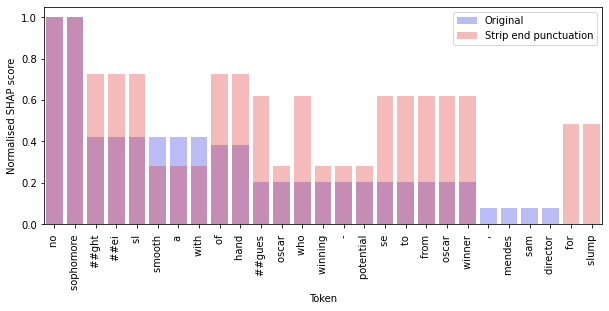

Original sentence: Too much of the humor falls flat .
Model prediction: 1
Top-5 intersection: 1.0
Spearman: 0.88


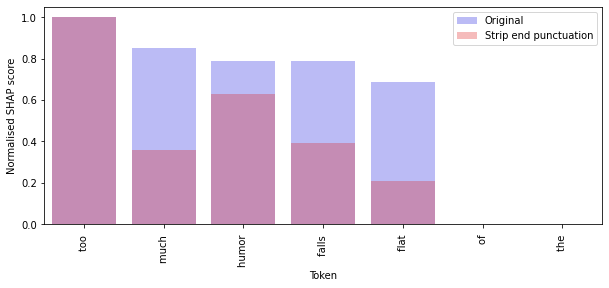

Original sentence: It 's a demented kitsch mess ( although the smeary digital video does match the muddled narrative ) , but it 's savvy about celebrity and has more guts and energy than much of what will open this year .
Model prediction: 3
Top-5 intersection: 0.8
Spearman: 0.97


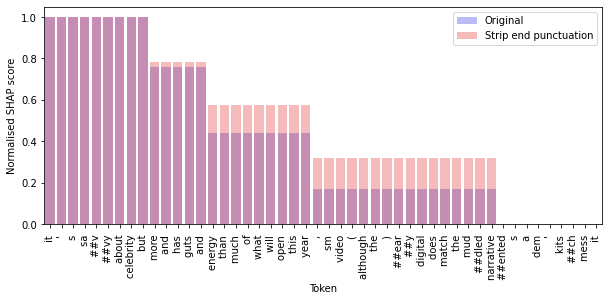

Original sentence: It 's basically an overlong episode of Tales from the Crypt .
Model prediction: 1
Top-5 intersection: 1.0
Spearman: 1.0


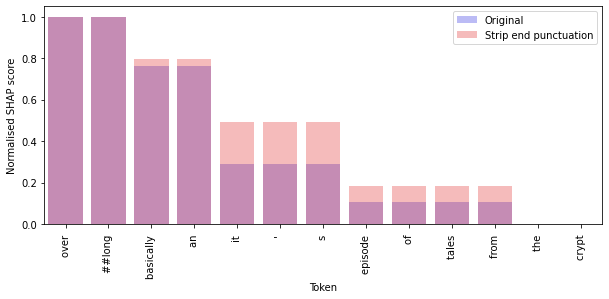




remove_commas

Original sentence: There are simply too many ideas floating around -- part farce , part Sliding Doors , part pop video -- and yet failing to exploit them .
Model prediction: 1
Top-5 intersection: 0.6
Spearman: 0.52


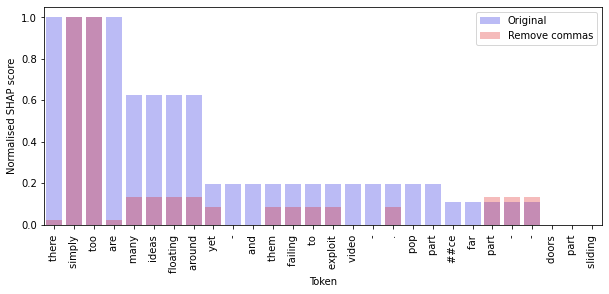

Original sentence: ... Designed to provide a mix of smiles and tears , `` Crossroads '' instead provokes a handful of unintentional howlers and numerous yawns .
Model prediction: 1
Top-5 intersection: 0.0
Spearman: 0.67


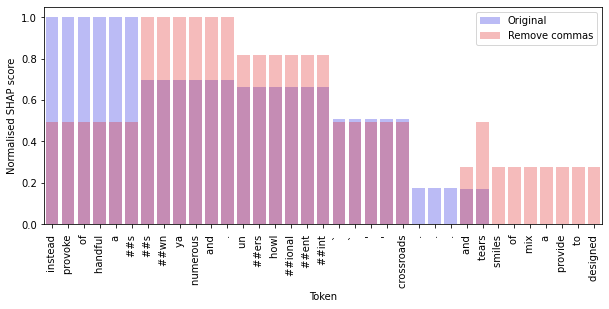

Original sentence: The movie is Dawn of the Dead crossed with John Carpenter 's Ghosts of Mars , with zombies not as ghoulish as the first and trains not as big as the second .
Model prediction: 1
Top-5 intersection: 0.0
Spearman: 0.13


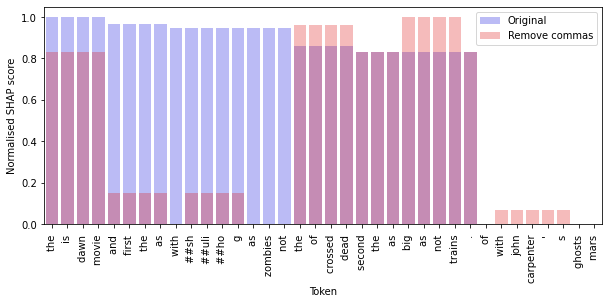

Original sentence: An exhilarating futuristic thriller-noir , Minority Report twists the best of technology around a gripping story , delivering a riveting , pulse intensifying escapist adventure of the first order
Model prediction: 4
Top-5 intersection: 0.0
Spearman: 0.35


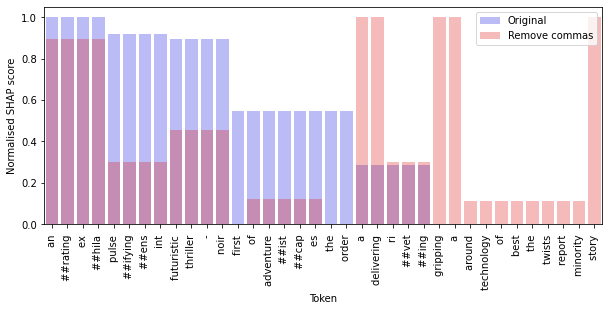

Original sentence: Charles ' entertaining film chronicles Seinfeld 's return to stand-up comedy after the wrap of his legendary sitcom , alongside wannabe comic Adams ' attempts to get his shot at the big time .
Model prediction: 3
Top-5 intersection: 1.0
Spearman: 0.8


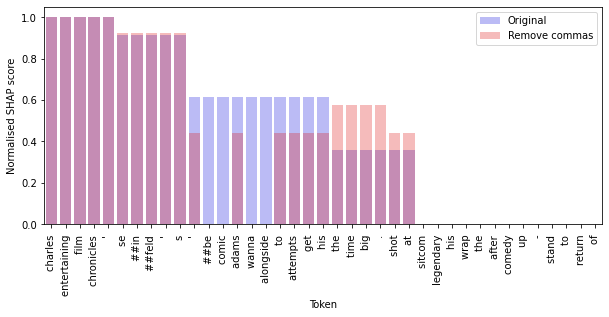




remove_all_punct

Original sentence: Writer/director Mark Romanek spotlights the underlying caste system in America .
Model prediction: 3
Top-5 intersection: 0.8
Spearman: 0.75


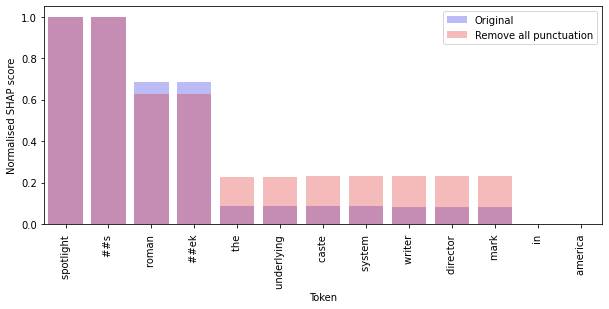

Original sentence: Seldom has a movie so closely matched the spirit of a man and his work .
Model prediction: 3
Top-5 intersection: 1.0
Spearman: 1.0


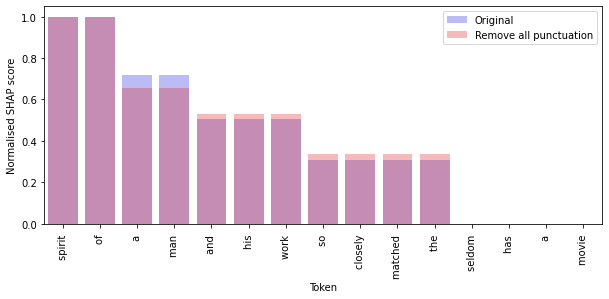

Original sentence: may not have generated many sparks , but with his affection for Astoria and its people he has given his tale a warm glow .
Model prediction: 3
Top-5 intersection: 1.0
Spearman: 0.92


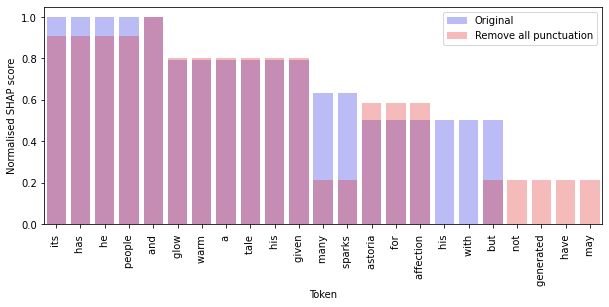

Original sentence: I 'm just too bored to care .
Model prediction: 1
Top-5 intersection: 0.8
Spearman: 0.57


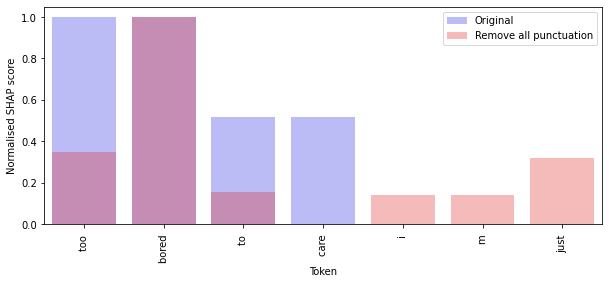

Original sentence: Like Mike is n't interested in recycling old cliches .
Model prediction: 1
Top-5 intersection: 0.6
Spearman: 0.22


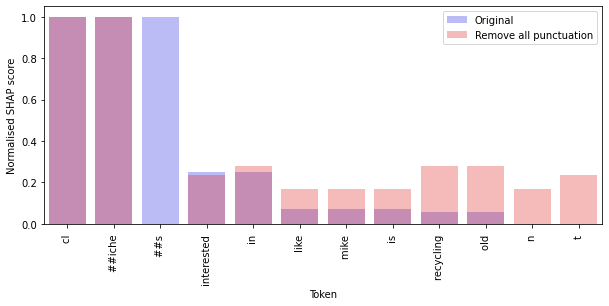




change_first_name

Original sentence: Neither Parker nor Donovan is a typical romantic lead , but they bring a fresh , quirky charm to the formula .
Model prediction: 3
Top-5 intersection: 1.0
Spearman: 1.0


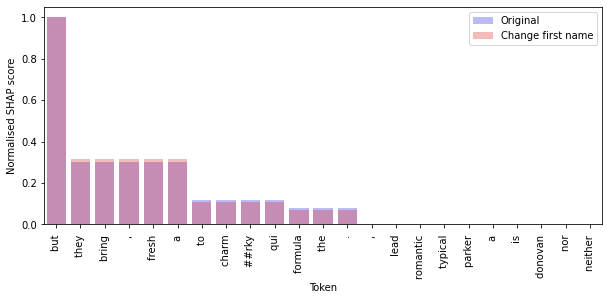

Original sentence: ( Lawrence bounces ) all over the stage , dancing , running , sweating , mopping his face and generally displaying the wacky talent that brought him fame in the first place .
Model prediction: 1
Top-5 intersection: 0.0
Spearman: 0.86


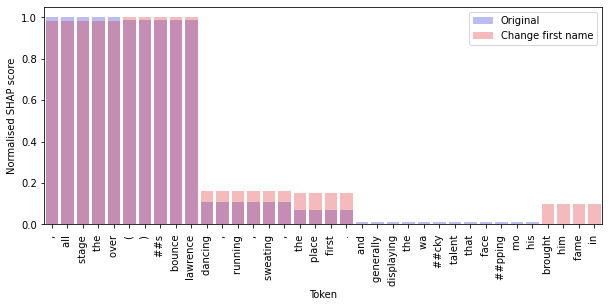

Original sentence: ( Lawrence bounces ) all over the stage , dancing , running , sweating , mopping his face and generally displaying the wacky talent that brought him fame in the first place .
Model prediction: 1
Top-5 intersection: 0.0
Spearman: 0.86


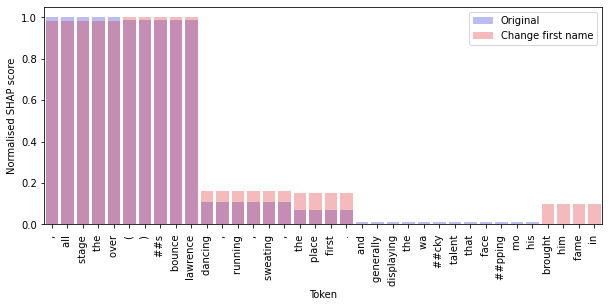

Original sentence: To say this was done better in Wilder 's Some Like It Hot is like saying the sun rises in the east .
Model prediction: 1
Top-5 intersection: 0.8
Spearman: 0.97


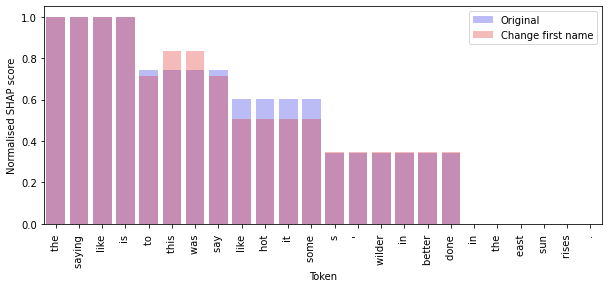

Original sentence: Neither Parker nor Donovan is a typical romantic lead , but they bring a fresh , quirky charm to the formula .
Model prediction: 3
Top-5 intersection: 1.0
Spearman: 1.0


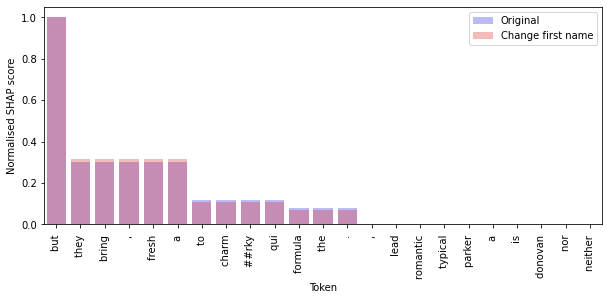




change_last_name

Original sentence: While there 's something intrinsically funny about Sir Anthony Hopkins saying ` Get in the car , bitch , ' this Jerry Bruckheimer production has little else to offer
Model prediction: 1
Top-5 intersection: 1.0
Spearman: 0.99


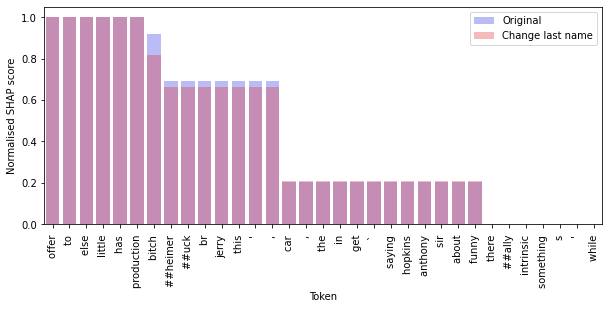

Original sentence: There 's just no currency in deriding James Bond for being a clichéd , doddering , misogynistic boy 's club .
Model prediction: 0
Top-5 intersection: 1.0
Spearman: 0.98


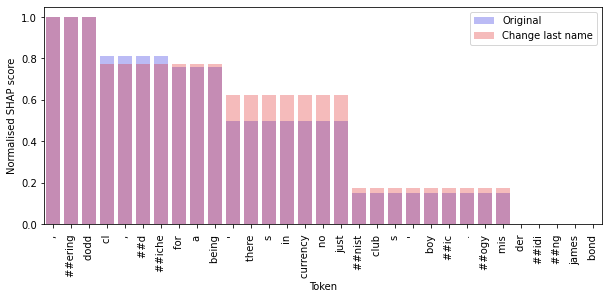

Original sentence: Van Wilder does n't bring anything new to the proverbial table , but it does possess a coherence absent in recent crass-a-thons like Tomcats , Freddy Got Fingered , and Slackers .
Model prediction: 2
Top-5 intersection: 0.0
Spearman: 0.85


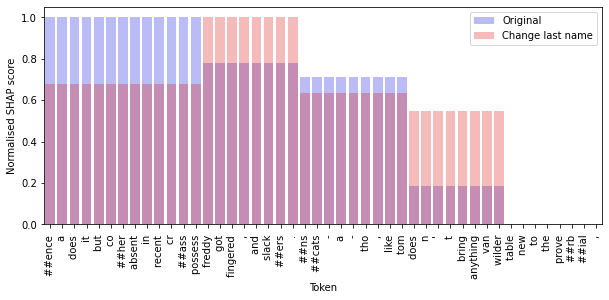

Original sentence: ... Brian De Palma is utterly mad : cinema mad , set-piece mad , style mad .
Model prediction: 0
Top-5 intersection: 1.0
Spearman: 0.97


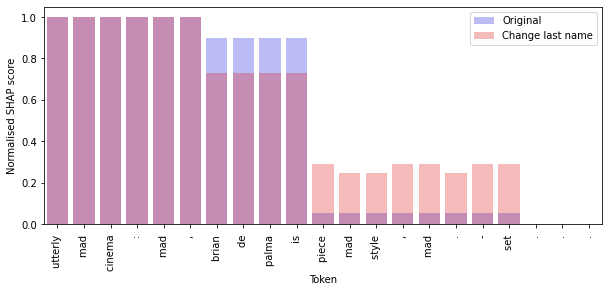

Original sentence: Harland Williams is so funny in drag he should consider permanent sex-reassignment .
Model prediction: 1
Top-5 intersection: 1.0
Spearman: 1.0


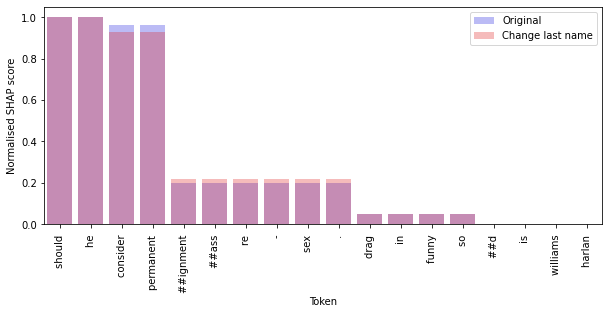




change_location

Original sentence: With its dogged Hollywood naturalism and the inexorable passage of its characters toward sainthood , Windtalkers is nothing but a sticky-sweet soap .
Model prediction: 1
Top-5 intersection: 1.0
Spearman: 0.9


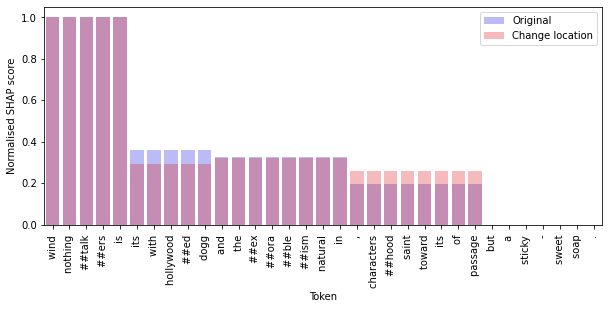

Original sentence: K-19 exploits our substantial collective fear of nuclear holocaust to generate cheap Hollywood tension .
Model prediction: 1
Top-5 intersection: 0.8
Spearman: 0.97


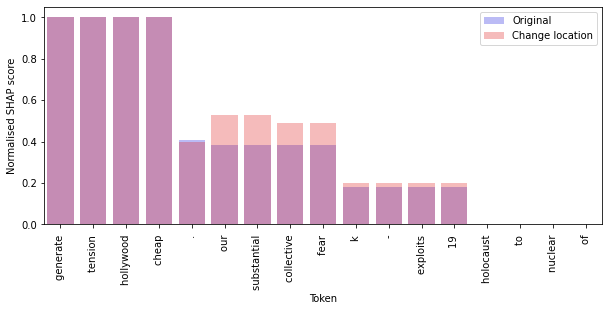

Original sentence: The overall effect is less like a children 's movie than a recruitment film for future Hollywood sellouts .
Model prediction: 1
Top-5 intersection: 0.8
Spearman: 0.9


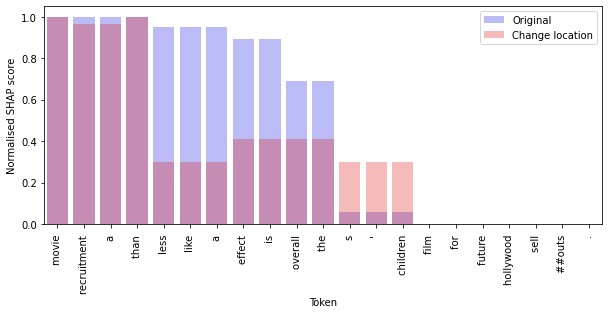

Original sentence: With its dogged Hollywood naturalism and the inexorable passage of its characters toward sainthood , Windtalkers is nothing but a sticky-sweet soap .
Model prediction: 1
Top-5 intersection: 1.0
Spearman: 0.9


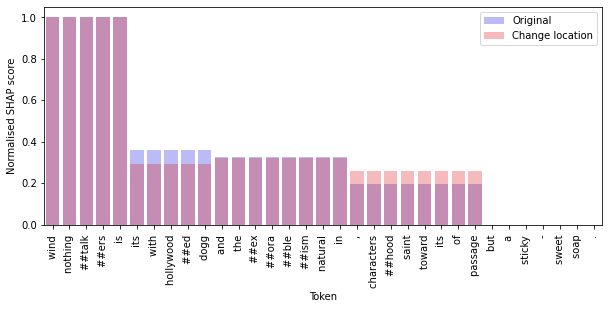

Original sentence: Nothing in Waking Up in Reno ever inspired me to think of its inhabitants as anything more than markers in a screenplay .
Model prediction: 1
Top-5 intersection: 1.0
Spearman: 0.94


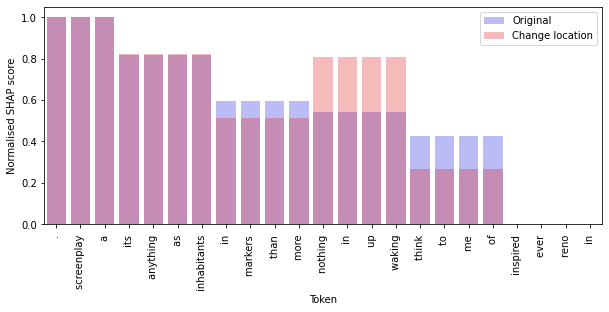




add_typo

Original sentence: The reality of the new live-action Pinocchio he directed , cowrote and starred in borders on the grotesque .
Model prediction: 2
Top-5 intersection: 1.0
Spearman: 1.0


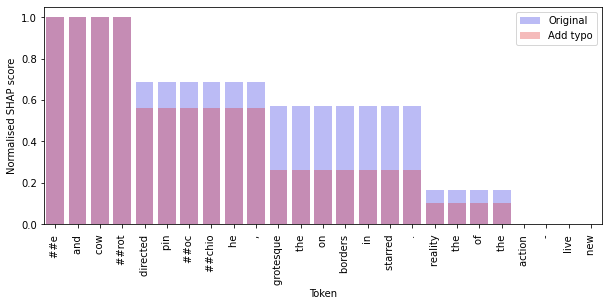

Original sentence: Fresnadillo 's dark and jolting images have a way of plying into your subconscious like the nightmare you had a week ago that wo n't go away .
Model prediction: 3
Top-5 intersection: 1.0
Spearman: 0.99


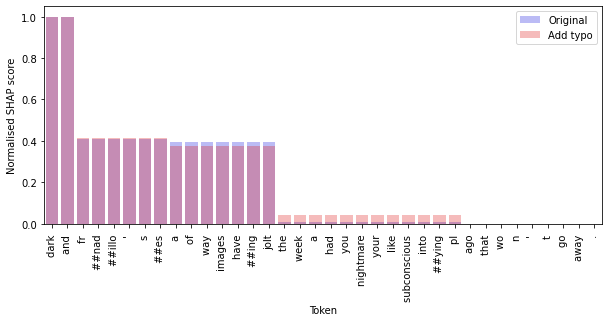

Original sentence: A densely constructed , highly referential film , and an audacious return to form that can comfortably sit among Jean-Luc Godard 's finest work .
Model prediction: 4
Top-5 intersection: 0.8
Spearman: 0.06


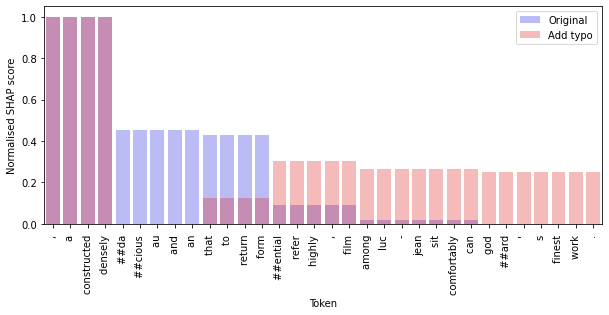

Original sentence: The movie is Dawn of the Dead crossed with John Carpenter 's Ghosts of Mars , with zombies not as ghoulish as the first and trains not as big as the second .
Model prediction: 1
Top-5 intersection: 0.8
Spearman: 0.71


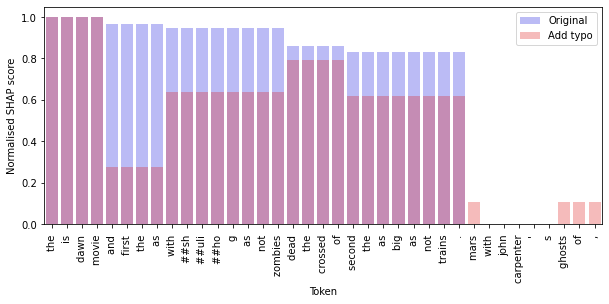

Original sentence: Perceptive in its vision of nascent industrialized world politics as a new art form , but far too clunky , didactic and saddled with scenes that seem simply an ill fit for this movie .
Model prediction: 1
Top-5 intersection: 0.6
Spearman: 0.94


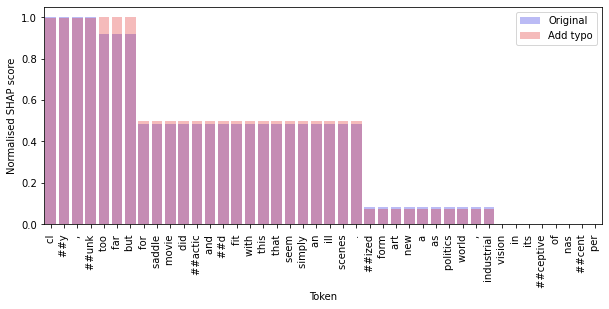




switch_gender

Original sentence: The special effects and many scenes of weightlessness look as good or better than in the original , while the Oscar-winning sound and James Horner 's rousing score make good use of the hefty audio system .
Model prediction: 3
Top-5 intersection: 1.0
Spearman: 1.0


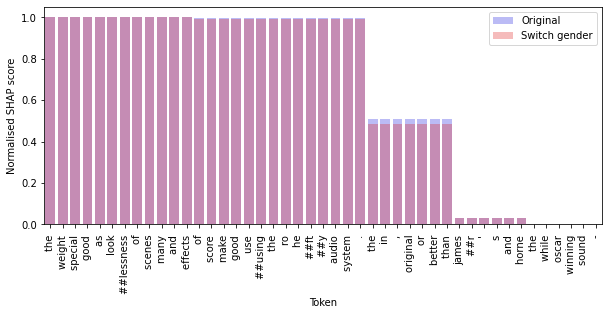

Original sentence: Pumpkin means to be an outrageous dark satire on fraternity life , but its ambitions far exceed the abilities of writer Adam Larson Broder and his co-director , Tony R. Abrams , in their feature debut .
Model prediction: 1
Top-5 intersection: 1.0
Spearman: 1.0


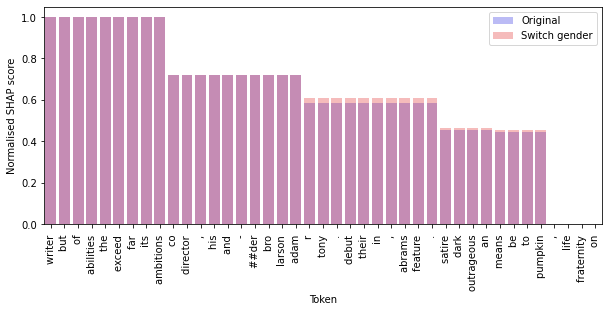

Original sentence: It 's a work by an artist so in control of both his medium and his message that he can improvise like a jazzman .
Model prediction: 3
Top-5 intersection: 1.0
Spearman: 1.0


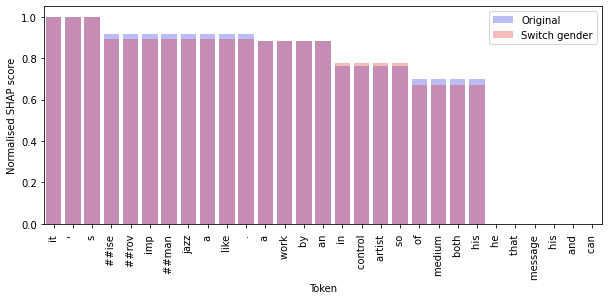

Original sentence: Montias ... pumps a lot of energy into his nicely nuanced narrative and surrounds himself with a cast of quirky -- but not stereotyped -- street characters .
Model prediction: 3
Top-5 intersection: 1.0
Spearman: 0.99


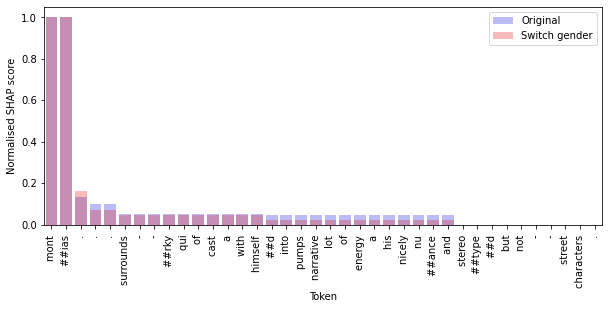

Original sentence: Broomfield turns his distinctive ` blundering ' style into something that could really help clear up the case .
Model prediction: 3
Top-5 intersection: 0.2
Spearman: 0.85


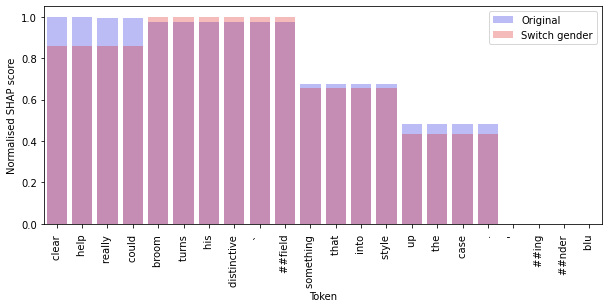




swap_adj

Original sentence: For anyone unfamiliar with pentacostal practices in general and theatrical phenomenon of Hell Houses in particular , it 's an eye-opener .
Model prediction: 3
Top-5 intersection: 1.0
Spearman: 0.83


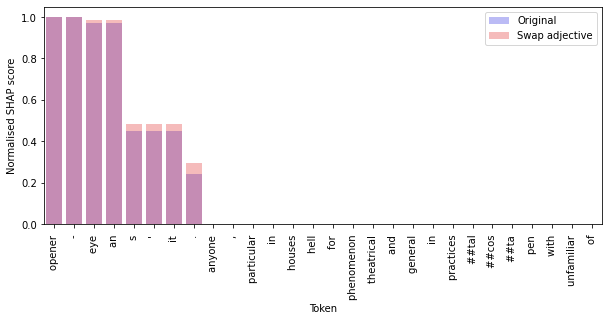

Original sentence: deliriously funny , fast and loose , accessible to the uninitiated , and full of surprises
Model prediction: 4
Top-5 intersection: 1.0
Spearman: 1.0


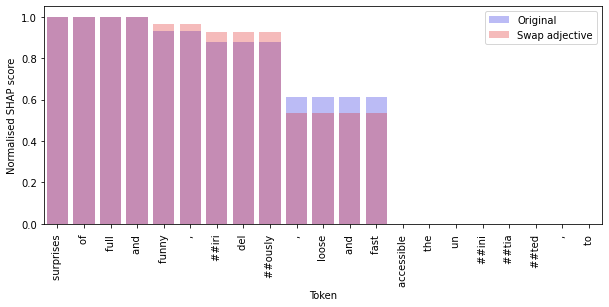

Original sentence: The film will play equally well on both the standard and giant screens .
Model prediction: 3
Top-5 intersection: 1.0
Spearman: 0.95


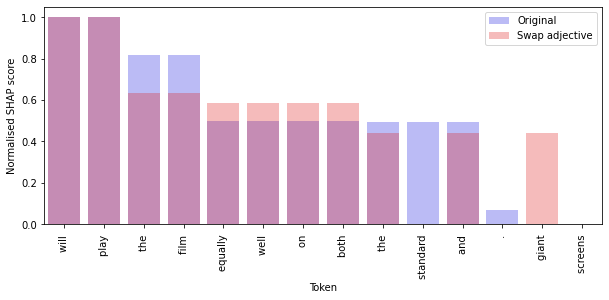

Original sentence: For all its technical virtuosity , the film is so mired in juvenile and near-xenophobic pedagogy that it 's enough to make one pine for the day when Godard can no longer handle the rigors of filmmaking .
Model prediction: 1
Top-5 intersection: 0.6
Spearman: 0.73


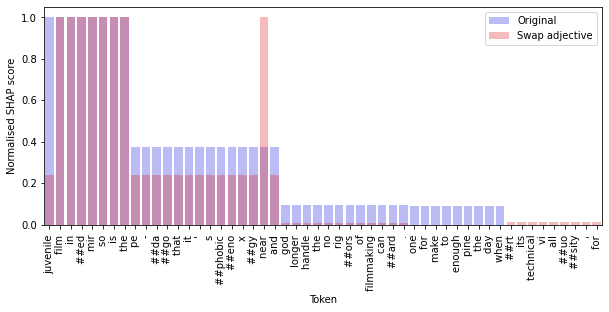

Original sentence: For anyone unfamiliar with pentacostal practices in general and theatrical phenomenon of Hell Houses in particular , it 's an eye-opener .
Model prediction: 3
Top-5 intersection: 1.0
Spearman: 0.83


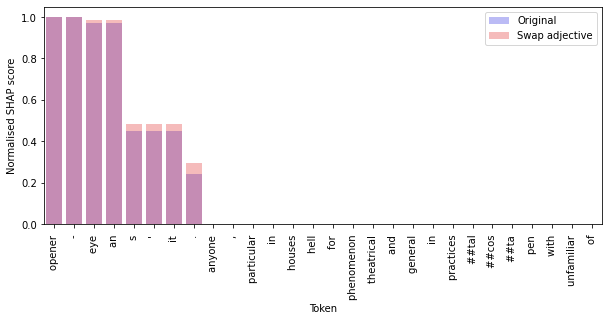

In [13]:
for pert in perturbation_df_dict.keys():
    print(
f"""
================================================
{pert}
================================================
"""
)
    plot_examples(perturbation=pert, num_examples=5)
    print('\n')

## Check examples

In [14]:
%%capture

pert = 'remove_all_punct'

example_df = plot_examples(perturbation=pert, num_examples=5, return_df=True)

In [15]:
example_df.head()

,shap_orig_tokens,shap_orig_values,shap_remove_all_punct_tokens,shap_remove_all_punct_values
0,hilarious,1.000000,hilarious,0.987652
1,film,1.000000,film,0.987652
2,that,1.000000,that,0.987652
3,reminded,1.000000,reminded,0.987652
4,of,0.935009,of,1.000000


In [16]:
# Check tokens the same
assert (
    example_df['shap_orig_tokens'].values == 
    example_df[f'shap_{pert}_tokens'].values
).mean() == 1

In [17]:
%%capture

pert = 'switch_gender'

example_df = plot_examples(perturbation=pert, num_examples=5, return_df=True)

In [18]:
# Check token switch
example_df[
    example_df['shap_orig_tokens'].values != 
    example_df[f'shap_{pert}_tokens'].values
]

,shap_orig_tokens,shap_orig_values,shap_switch_gender_tokens,shap_switch_gender_values
12,his,0.71962,her,0.718253


In [19]:
%%capture

pert = 'add_typo'

example_df = plot_examples(perturbation=pert, num_examples=5, return_df=True)

In [20]:
# Check token switch
example_df[
    example_df['shap_orig_tokens'].values != 
    example_df[f'shap_{pert}_tokens'].values
]

,shap_orig_tokens,shap_orig_values,shap_add_typo_tokens,shap_add_typo_values
6,##s,0.836314,so,0.0
7,of,0.836314,##f,0.0


In [21]:
%%capture

pert = 'swap_adj'

example_df = plot_examples(perturbation=pert, num_examples=5, return_df=True)

In [22]:
# Check token switch
example_df[
    example_df['shap_orig_tokens'].values != 
    example_df[f'shap_{pert}_tokens'].values
]

,shap_orig_tokens,shap_orig_values,shap_swap_adj_tokens,shap_swap_adj_values
16,theatrical,0.0,general,0.000000e+00
18,general,0.0,theatrical,6.938894e-18


## 2. AG News

In [23]:
perturbation_df_dict = pickle.load(open('data/processed/perturbation_df_dict_AGNews_BERT.pickle', 'rb'))

In [24]:
perturbation_df_dict.keys()

dict_keys(['strip_punct', 'remove_commas', 'remove_all_punct', 'change_first_name', 'change_last_name', 'change_location', 'add_typo', 'switch_gender', 'swap_adj'])

## Generate table heatmap
#### Note correction to k-intersection calculation

In [25]:
results_dict = {}

k=5
  
for perturbation, df in perturbation_df_dict.items():
    if df is None:
        continue

    df['top_k_idx_orig'] = df.apply(lambda x: set(np.argsort(-np.array(x[f'shap_orig_values']))[:k]), axis=1)
    df['top_k_idx_perturb'] = df.apply(lambda x: set(np.argsort(-x[f'shap_{perturbation}_values'])[:k]), axis=1)

    df['k_intersection'] = df.apply(lambda x: len(x['top_k_idx_orig'].intersection(x['top_k_idx_perturb'])) / k, axis=1)
    
    df['spearman'] = df.apply(lambda x: spearmanr(x['shap_orig_values'], x[f'shap_{perturbation}_values'])[0], axis=1)
    
    results_dict[perturbation] = {
        'top_k_mean': df['k_intersection'].mean(),
        'top_k_std': df['k_intersection'].std(),
        'spearman_mean': df['spearman'].mean(),
        'spearman_std': df['spearman'].std()
    }

In [26]:
results_df = pd.DataFrame(results_dict).T
results_df.rename(index=PERTURBATION_FULL_FORM_DICT, columns={'top_k_mean': 'Mean top-5 intersection (± sd)', 'spearman_mean': "Mean Spearman (± sd)"}, inplace=True)
results_df

,Mean top-5 intersection (± sd),top_k_std,Mean Spearman (± sd),spearman_std
Strip end punctuation,0.771111,0.316754,0.872360,0.222262
Remove commas,0.468750,0.393626,0.572320,0.374721
Remove all punctuation,0.428085,0.352855,0.518757,0.354435
Change first name,0.851852,0.277088,0.919937,0.149176
Change last name,0.884000,0.255838,0.940424,0.126621
Change location,0.898246,0.214219,0.914852,0.154090
Add typo,0.836364,0.300072,0.874396,0.170384
Switch gender,0.910870,0.186026,0.935079,0.130559
Swap adjective,0.733333,0.384550,0.910803,0.120745


In [27]:
# Create string labels with mean and std
for i in range(10):
    results_df[f'label_top_k'] = np.round(results_df[f'Mean top-5 intersection (± sd)'], 2).astype(str) + ' (±' + np.round(results_df[f'top_k_std'], 2).astype(str) + ')'
    results_df[f'label_spearman'] = np.round(results_df[f'Mean Spearman (± sd)'], 2).astype(str) + ' (±' + np.round(results_df[f'spearman_std'], 2).astype(str) + ')'

In [28]:
results_df

,Mean top-5 intersection (± sd),top_k_std,Mean Spearman (± sd),spearman_std,label_top_k,label_spearman
Strip end punctuation,0.771111,0.316754,0.872360,0.222262,0.77 (±0.32),0.87 (±0.22)
Remove commas,0.468750,0.393626,0.572320,0.374721,0.47 (±0.39),0.57 (±0.37)
Remove all punctuation,0.428085,0.352855,0.518757,0.354435,0.43 (±0.35),0.52 (±0.35)
Change first name,0.851852,0.277088,0.919937,0.149176,0.85 (±0.28),0.92 (±0.15)
Change last name,0.884000,0.255838,0.940424,0.126621,0.88 (±0.26),0.94 (±0.13)
Change location,0.898246,0.214219,0.914852,0.154090,0.9 (±0.21),0.91 (±0.15)
Add typo,0.836364,0.300072,0.874396,0.170384,0.84 (±0.3),0.87 (±0.17)
Switch gender,0.910870,0.186026,0.935079,0.130559,0.91 (±0.19),0.94 (±0.13)
Swap adjective,0.733333,0.384550,0.910803,0.120745,0.73 (±0.38),0.91 (±0.12)


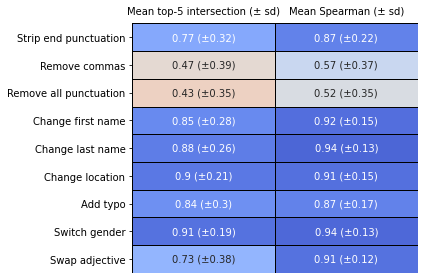

In [29]:
sns.heatmap(
    results_df.drop(['top_k_std', 'spearman_std', 'label_top_k', 'label_spearman'], axis=1), 
    cbar=False, 
    vmin=0,
    vmax=1,
    annot=results_df[['label_top_k', 'label_spearman']].values,
    fmt='',
    cmap='coolwarm_r', 
    linewidths=1, 
    linecolor='black'
)
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom=False, bottom=False, top=False, labeltop=True)
plt.tight_layout()
plt.show()

### Explore individual cases


strip_punct

Original sentence: ANAHEIM -- Suddenly, being Canada';s undisputed National Team comes with a burden, the Toronto Blue Jays seem to understand. Getting prominent Canadian natives into a Toronto uniform is part of the responsibility.
Model prediction: 1
Top-5 intersection: 1.0
Spearman: 0.98


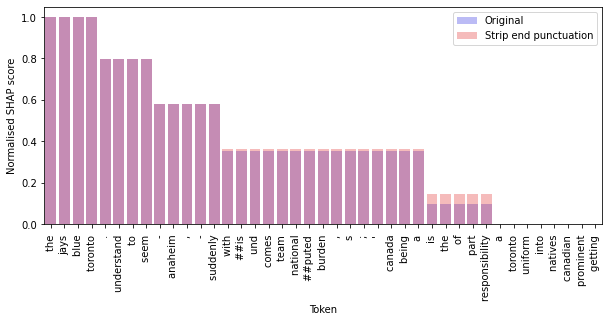

Original sentence: T.J. Duckett set a team record by rushing for four touchdowns and the Atlanta Falcons clinched just the third division title in franchise history, wrapping up the NFC South with a 35-10 rout of the Oakland Raiders on Sunday.
Model prediction: 1
Top-5 intersection: 1.0
Spearman: 0.99


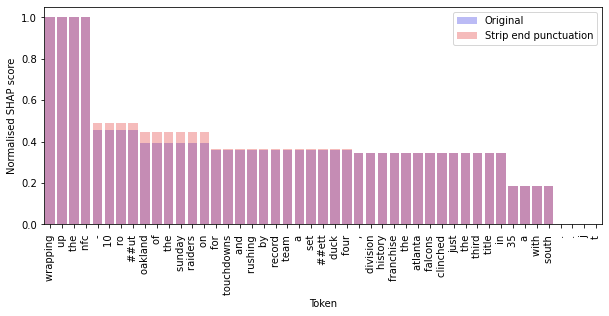

Original sentence: NASHVILLE, Tenn. -- A phantom penalty and a nine-yard touchdown catch by Eddie Kennison on Monday night lifted the Kansas City Chiefs past the Tennessee Titans, 49-38.
Model prediction: 1
Top-5 intersection: 0.4
Spearman: 0.3


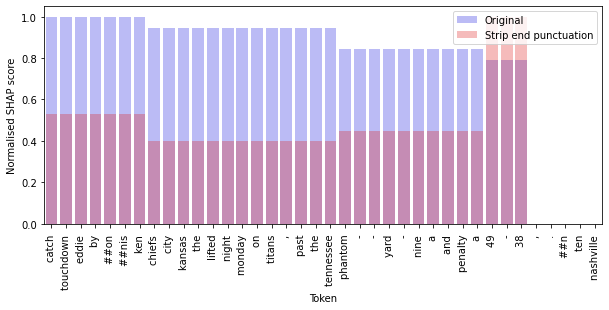

Original sentence: AP - FIRST ON TAP: President Bush was meeting Monday with nine new senators and 41 new representatives joining the 109th Congress in a session that a spokesman said was aimed at "coming together."
Model prediction: 0
Top-5 intersection: 0.0
Spearman: 0.33


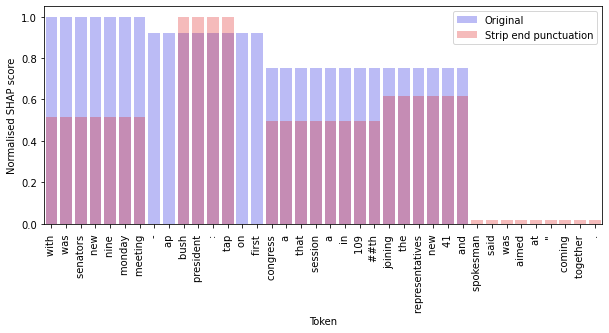

Original sentence: Are these guys ever going to have a game that doesn';t come down to the last possession? It seems that, if nothing else, the Celtics give you 48 minutes worth.
Model prediction: 1
Top-5 intersection: 1.0
Spearman: 0.95


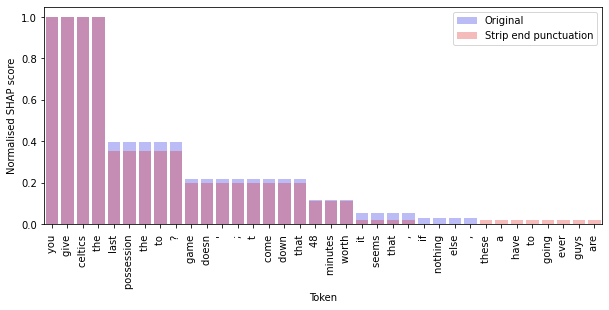




remove_commas

Original sentence: AP - Kidde PLC, the British fire and safety company, said Thursday it had agreed to a 1.4 billion pound ( #36;2.8 billion) takeover by United Technologies Corp.
Model prediction: 0
Top-5 intersection: 1.0
Spearman: 0.61


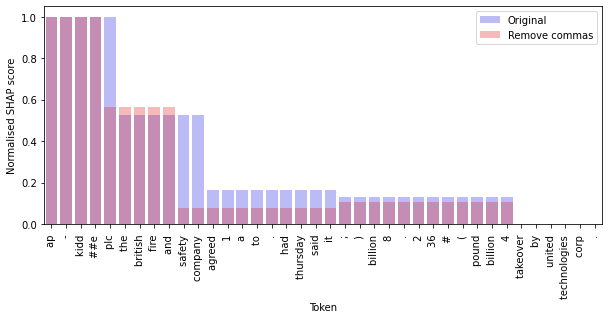

Original sentence: EAST RUTHERFORD, N.J. -- Tiki Barber scored on a 3-yard run with 11 seconds to play and Eli Manning threw three touchdown passes as the Giants edged the Dallas Cowboys, 28-24, last night in a wild finale to the NFL regular season.The late heroics provided Manning with his first career victory and spoiled a great effort by Cowboys quarterback Vinny ...
Model prediction: 1
Top-5 intersection: 0.4
Spearman: 0.49


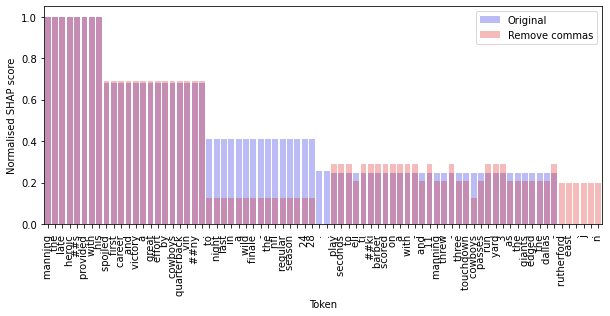

Original sentence: (New York -WABC, December 17, 2004) - The New York Yankees already are close to completing deals with starting pitchers Carl Pavano and Jaret Wright.
Model prediction: 1
Top-5 intersection: 0.0
Spearman: 0.81


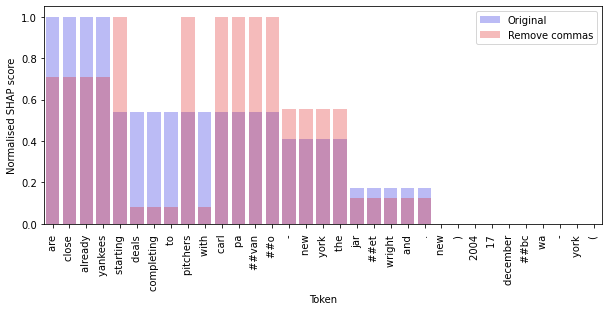

Original sentence: Women opting for a Caesarean should be warned there is a small chance that it will jeopardise later natural births, say experts.
Model prediction: 0
Top-5 intersection: 0.6
Spearman: 0.94


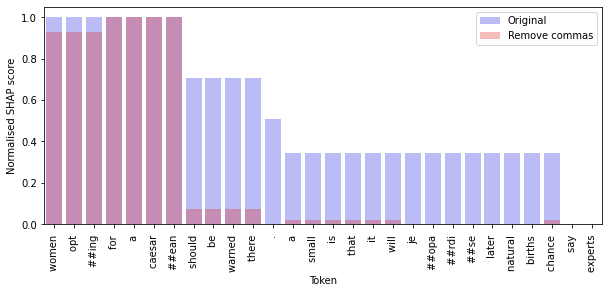

Original sentence: NEW HAVEN, Conn. The Connecticut financier who stole more than 200 (m) million dollars from insurance companies in Tennessee and other states to finance a lavish lifestyle will ask for a reduced prison sentence.
Model prediction: 2
Top-5 intersection: 0.2
Spearman: 0.83


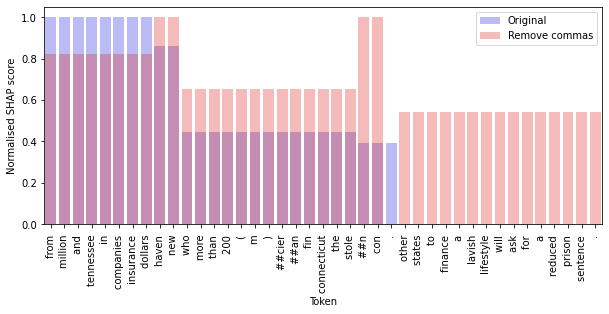




remove_all_punct

Original sentence:  NEW YORK (Reuters) - Peyton Manning continued to close in  on the NFL record for single season touchdown passes on Sunday,  firing two TD strikes as the Indianapolis Colts eased past the  Houston Texans 23-14 to clinch the division title.
Model prediction: 1
Top-5 intersection: 0.4
Spearman: 0.03


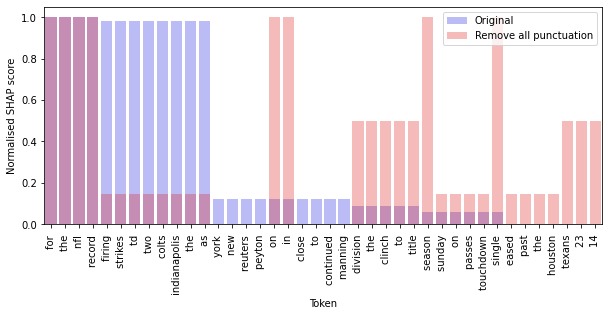

Original sentence: A Moscow court has barred the embattled Russian oil giant Yukos from holding an emergency shareholders meeting next week, a Russian oil company official said Thursday.
Model prediction: 2
Top-5 intersection: 0.4
Spearman: 0.88


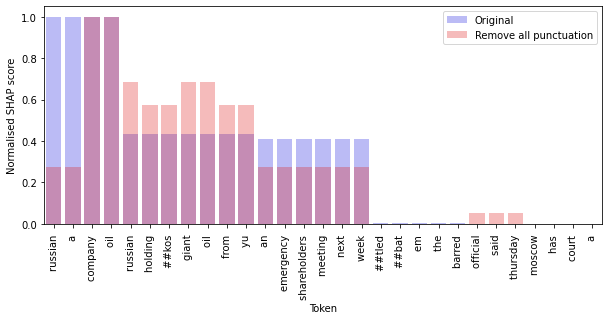

Original sentence: Oracle announces a blowout quarter and a deal for PeopleSoft at $26.50 per share.
Model prediction: 2
Top-5 intersection: 0.4
Spearman: 0.15


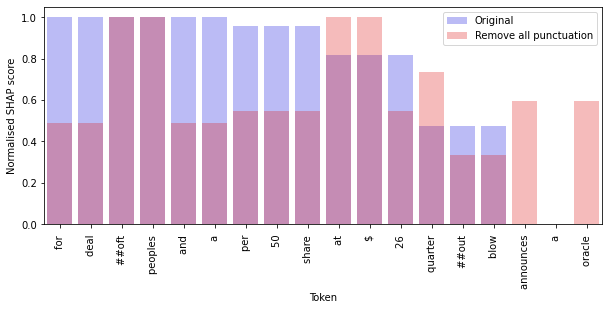

Original sentence: Any hope of saving the NHL season hinges on whether the next proposal by the Players Association stirs serious negotiating.
Model prediction: 1
Top-5 intersection: 0.8
Spearman: 0.91


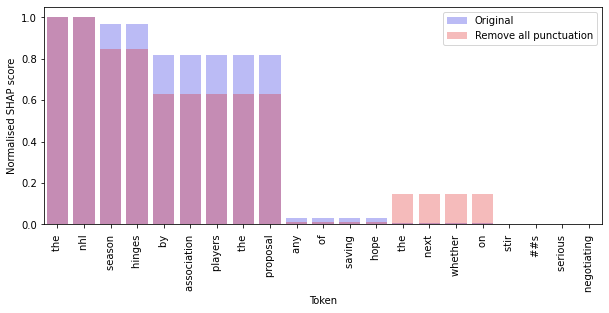

Original sentence: The year 2004 was the fourth hottest ever recorded and the past decade was the warmest since measurements began in 1861, the World Meteorological Organisation said Wednesday.
Model prediction: 3
Top-5 intersection: 0.4
Spearman: 0.48


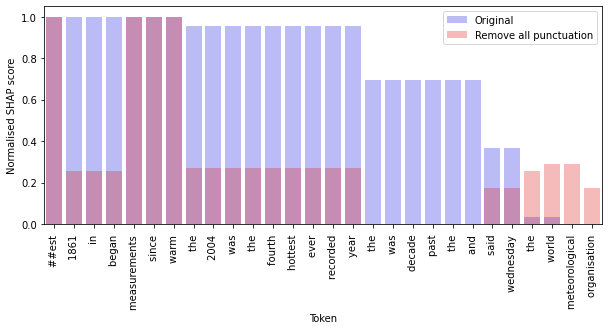




change_first_name

Original sentence: AP - Pops Mensah-Bonsu scored 17 points, and No. 21 George Washington used a 20-2 run late in the first half to take control in a 79-65 victory Saturday night over St. Francis, Pa.
Model prediction: 1
Top-5 intersection: 1.0
Spearman: 1.0


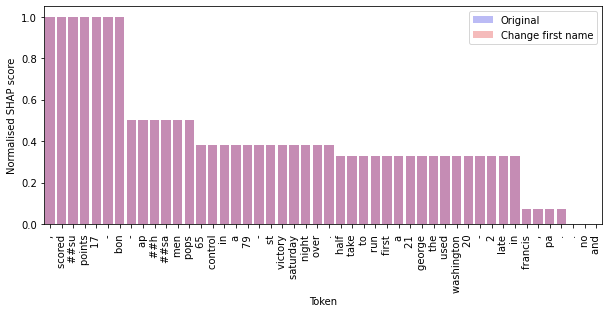

Original sentence: The BBC's Rachel Harvey meets a fisherman in the Indonesian city of Banda Aceh who survived the tsunami.
Model prediction: 0
Top-5 intersection: 1.0
Spearman: 1.0


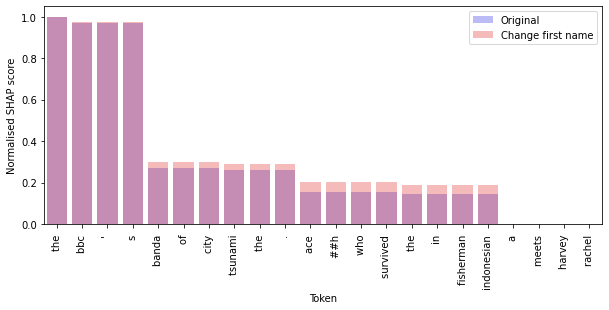

Original sentence: Napster creator Shawn Fanning introduces a new licensed file-sharing service with unlimited choice of tracks.
Model prediction: 3
Top-5 intersection: 1.0
Spearman: 1.0


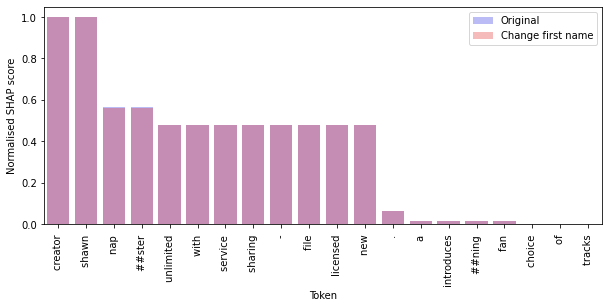

Original sentence: The ousting of fund president Sean Harrigan from Americas largest pension fund has been viewed by many as the first Republican victory in a battle to undermine the influence of pension funds like Calpers on corporate governance issues.
Model prediction: 2
Top-5 intersection: 0.8
Spearman: 1.0


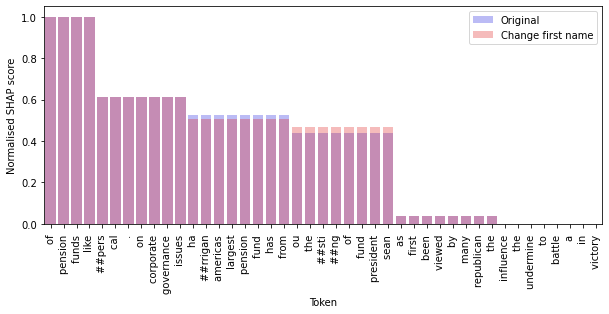

Original sentence: By Anthony Evans in Las Vegas pic by Mr Will : WBC heavyweight champion Vitali Klitschko has welcomed the news that bitter rival Lennox Lewis is considering a comeback with derision.
Model prediction: 1
Top-5 intersection: 0.8
Spearman: 0.97


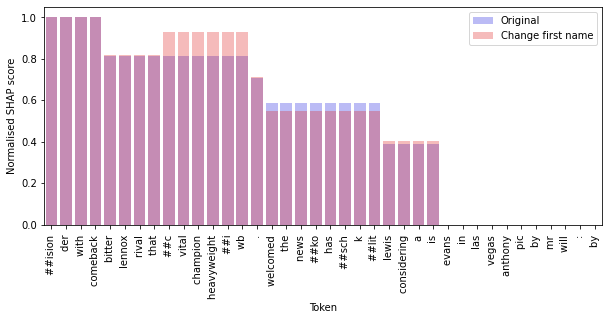




change_last_name

Original sentence:  SYDNEY (Reuters) - It is lucky for Michael Phelps that he  is blessed with broad shoulders and an arm span like the wings  on a jumbo jet. Not only does it enable him to swim like a fish  but it also helps him to carry the burden of his own great  expectations.
Model prediction: 1
Top-5 intersection: 0.8
Spearman: 0.84


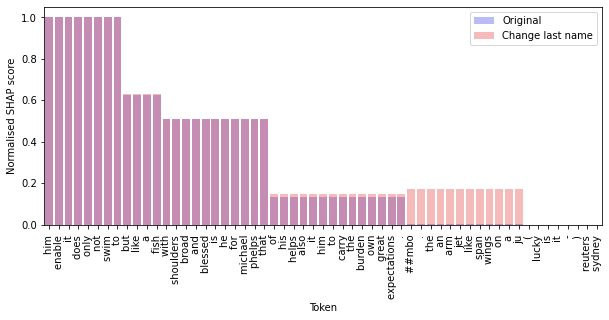

Original sentence: The Detroit Lions reached a six-year deal with Shaun Rogers yesterday, making him the highest-paid defensive tackle in the NFL, his agent said. Kennard McGuire would not reveal terms of the contract, but ESPN.com reported the deal was worth $46 million and included a $15 million signing bonus. Rogers, 25, was selected to the Pro Bowl this year and was ...
Model prediction: 1
Top-5 intersection: 0.2
Spearman: 0.99


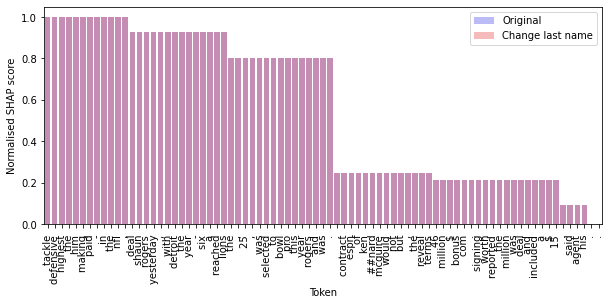

Original sentence: Defensive coordinator Kyle Whittingham replaces Urban Meyer as the new head coach at Utah on Wednesday.
Model prediction: 1
Top-5 intersection: 1.0
Spearman: 1.0


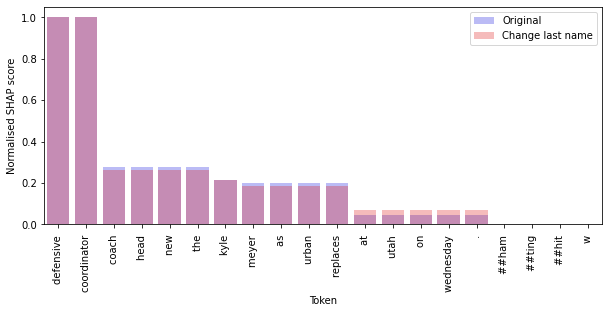

Original sentence: Utah football coach Urban Meyer was just where he was scheduled to be Thursday, at practice with his team. The New York Times reported earlier in the day that Meyer had been contacted by Notre Dame and that he would meet with school officials.
Model prediction: 1
Top-5 intersection: 1.0
Spearman: 0.99


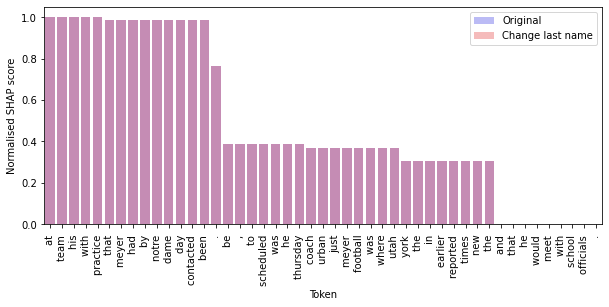

Original sentence: Rupert Murdoch has offered the highest price ever for a Manhattan residence to buy a penthouse once owned by the Rockefeller family.
Model prediction: 2
Top-5 intersection: 1.0
Spearman: 0.99


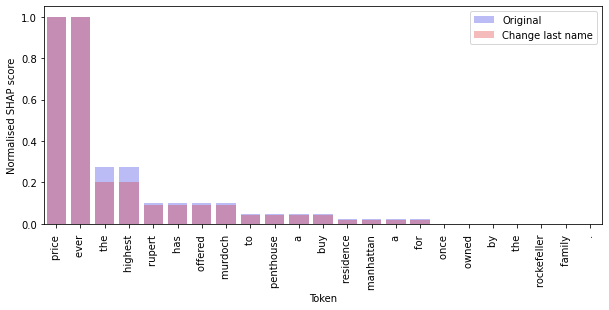




change_location

Original sentence:  AMSTERDAM (Reuters) - The European Union urged Liberia,  struggling to emerge from more than 10 years of civil war, to  bring its election laws up to international standards ahead of  an October vote.
Model prediction: 0
Top-5 intersection: 1.0
Spearman: 0.99


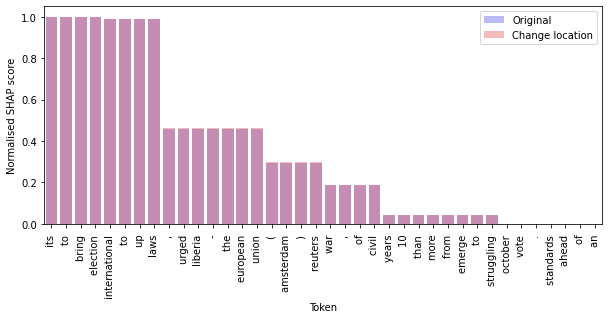

Original sentence: TONY EASTLEY: According to some news agencies, the US military passed a grim milestone this week, with 1,000 American troops killed in combat in Iraq.
Model prediction: 0
Top-5 intersection: 1.0
Spearman: 0.99


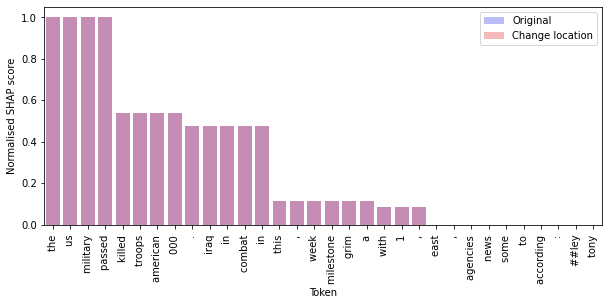

Original sentence: AFP - Eddie Griffin's National Basketball Association homecoming was more than the Philadelphia 76ers could handle.
Model prediction: 1
Top-5 intersection: 1.0
Spearman: 0.99


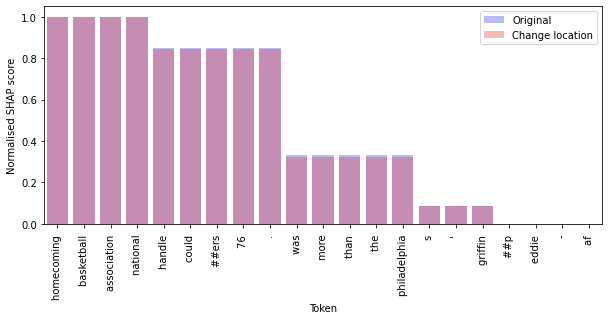

Original sentence: PalmSource is to create a new version of the Palm OS with Linux at its core, the company said today after announcing a plan to buy Chinese phone software company China MobileSoft (CMS';).
Model prediction: 3
Top-5 intersection: 0.8
Spearman: 0.92


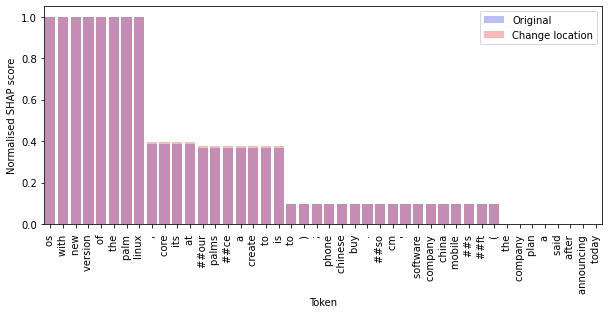

Original sentence: Get INQ7 breaking news on your Smart mobile phone in the Philippines. Send INQ7 BREAKING to 386. AUBURN HILLS, Michigan, United States of America -- National Basketball Association champions Detroit held LeBron 
Model prediction: 1
Top-5 intersection: 1.0
Spearman: 0.8


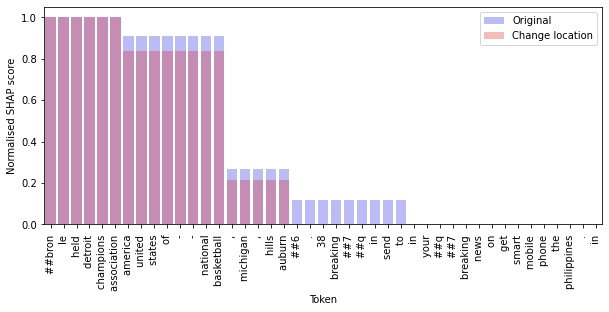




add_typo

Original sentence: The BBC's Rachel Harvey meets a fisherman in the Indonesian city of Banda Aceh who survived the tsunami.
Model prediction: 0
Top-5 intersection: 1.0
Spearman: 1.0


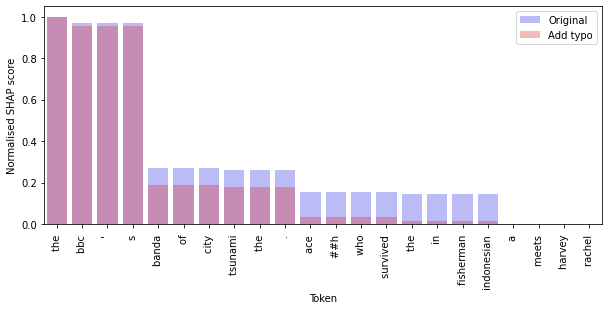

Original sentence: The BBC's Rachel Harvey meets a fisherman in the Indonesian city of Banda Aceh who survived the tsunami.
Model prediction: 0
Top-5 intersection: 1.0
Spearman: 1.0


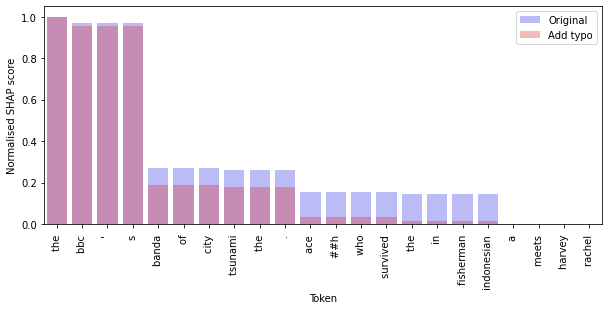

Original sentence: Late on Friday, an United Airlines plane will arrive in Vietnam';s Ho Chi Minh City, marking the first time that a commercial American airliner will be landing in the country since the Vietnam War.
Model prediction: 0
Top-5 intersection: 1.0
Spearman: 0.95


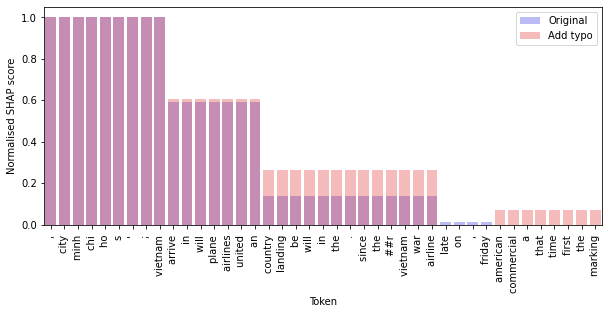

Original sentence: Late on Friday, an United Airlines plane will arrive in Vietnam';s Ho Chi Minh City, marking the first time that a commercial American airliner will be landing in the country since the Vietnam War.
Model prediction: 0
Top-5 intersection: 1.0
Spearman: 0.95


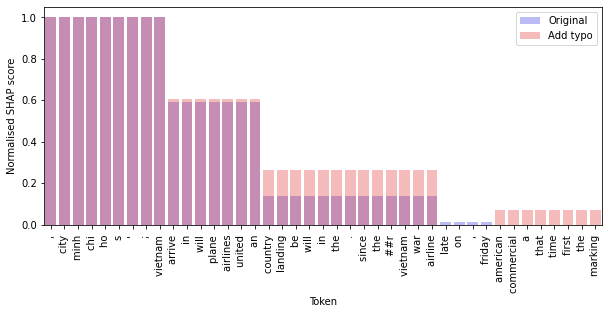

Original sentence:  BAGHDAD (Reuters) - A suicide car bomber struck at an  entrance to Baghdad's Green Zone government compound on  Tuesday, 24 hours after an almost identical attack on the same  checkpoint, a U.S. military spokesman and Iraqi police said.
Model prediction: 0
Top-5 intersection: 1.0
Spearman: 1.0


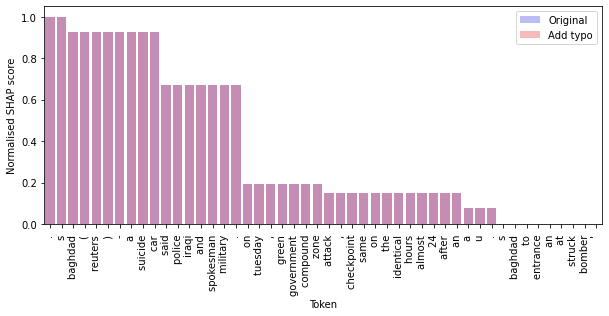




switch_gender

Original sentence: AP - Dusty Baker believes Barry Bonds didn't know the substances provided by his trainer were steroids.
Model prediction: 1
Top-5 intersection: 1.0
Spearman: 0.66


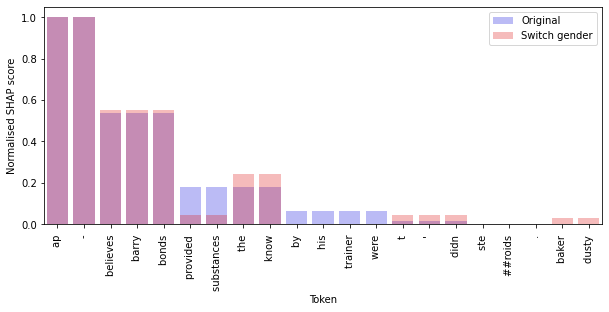

Original sentence: AP - Ukrainian prosecutors reopened their investigation into allegations Viktor Yushchenko was poisoned after doctors treating the opposition leader confirmed he had been slipped the toxic chemical dioxin, as Yushchenko returned home Sunday to campaign for this month's presidential runoff vote.
Model prediction: 0
Top-5 intersection: 1.0
Spearman: 1.0


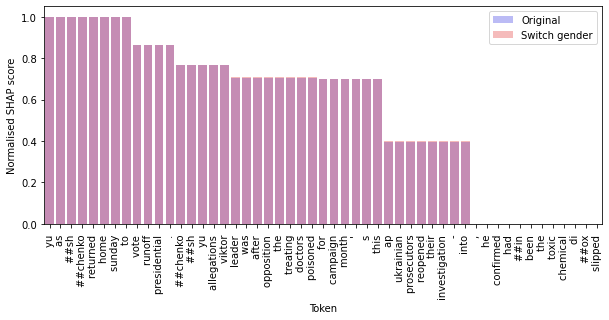

Original sentence: Kobe Bryant, the Los Angeles Lakers' star guard, got everything he wanted. Isn't that what everyone said last summer?
Model prediction: 1
Top-5 intersection: 1.0
Spearman: 0.84


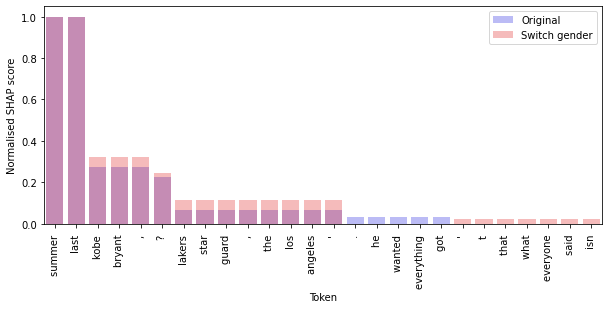

Original sentence: PERHAPS we should call him the Temperman from now on. Linguistic problems were an entertaining hallmark of Claudio Ranieris stint as Chelsea head coach, but on Tuesday night a misguided verbal 
Model prediction: 1
Top-5 intersection: 1.0
Spearman: 1.0


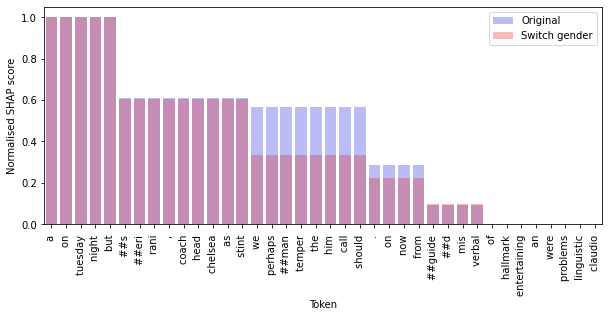

Original sentence: Charlie Weis says his job as Notre Dame';s new football coach is to raise expectations and win games. It';s as simple as that.
Model prediction: 1
Top-5 intersection: 1.0
Spearman: 0.98


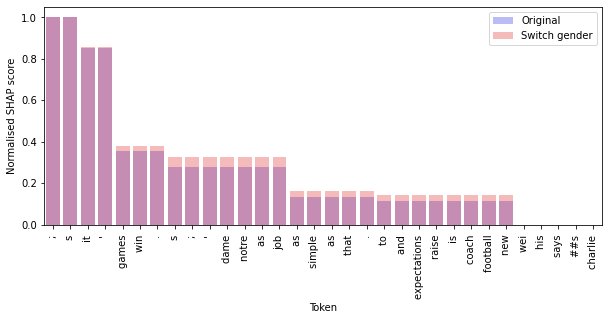




swap_adj

Original sentence:  VIENNA (Reuters) - Hans Knauss, one of the best known and  most experienced Austrian skiers, has tested positive for the  anabolic steroid nandrolone.
Model prediction: 1
Top-5 intersection: 0.6
Spearman: 0.98


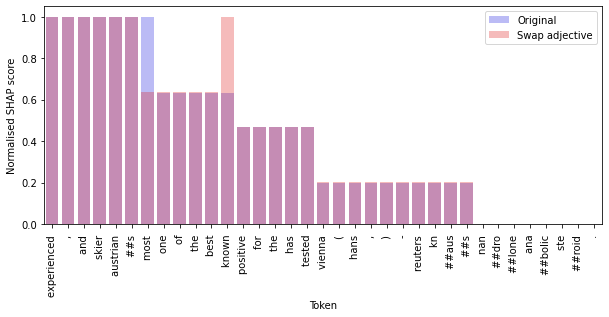

Original sentence: Chittagong, Dec. 18. Rahul Dravid fell for 160 while Sachin Tendulkar exited after making 36 runs on the second day of the second and final test between India and Bangladesh here today.
Model prediction: 1
Top-5 intersection: 0.0
Spearman: 0.59


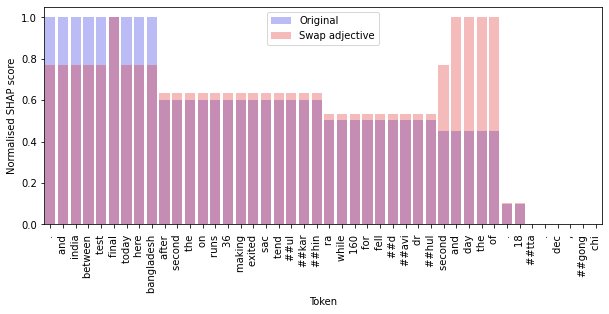

Original sentence:  PHILADELPHIA/NEW YORK (Reuters) - Sprint Corp. is in  advanced talks to buy Nextel Communications Inc. for more than  $36 billion in a mostly stock deal that would combine the No. 3  and No. 5 U.S. wireless service carriers, sources familiar with  the situation said on Friday.
Model prediction: 2
Top-5 intersection: 1.0
Spearman: 0.99


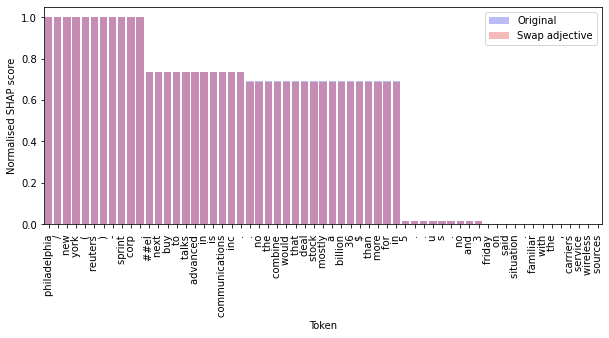

Original sentence: No players are pictured on the front or back covers of the Montana football media guide. Displayed instead are images of the two NCAA championship trophies the Grizzlies have won 
Model prediction: 1
Top-5 intersection: 1.0
Spearman: 0.93


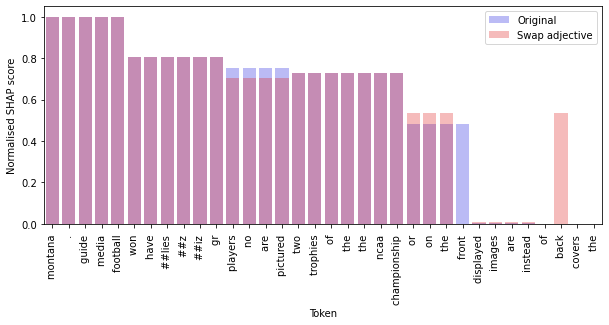

Original sentence:  PHILADELPHIA/NEW YORK (Reuters) - Sprint Corp. is in  advanced talks to buy Nextel Communications Inc. for more than  $36 billion in a mostly stock deal that would combine the No. 3  and No. 5 U.S. wireless service carriers, sources familiar with  the situation said on Friday.
Model prediction: 2
Top-5 intersection: 1.0
Spearman: 0.99


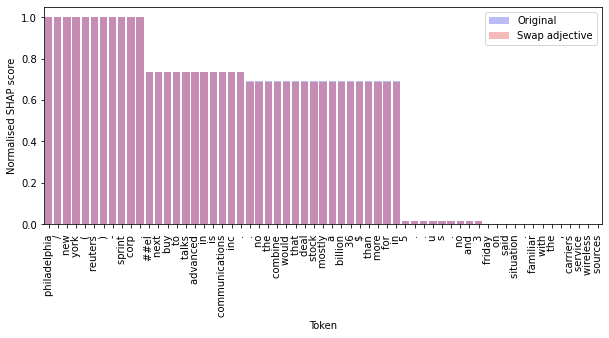

In [30]:
for pert in perturbation_df_dict.keys():
    print(
f"""
================================================
{pert}
================================================
"""
)
    plot_examples(perturbation=pert, num_examples=5)
    print('\n')

## Check examples

In [31]:
%%capture

pert = 'remove_all_punct'

example_df = plot_examples(perturbation=pert, num_examples=5, return_df=True)

In [32]:
example_df.head()

,shap_orig_tokens,shap_orig_values,shap_remove_all_punct_tokens,shap_remove_all_punct_values
0,##sel,1.0,##sel,0.007336
1,##beck,1.0,##beck,0.007336
2,quarterback,1.0,quarterback,0.399263
3,matt,1.0,matt,0.399263
4,has,1.0,has,0.007336


In [33]:
# Check tokens the same
assert (
    example_df['shap_orig_tokens'].values == 
    example_df[f'shap_{pert}_tokens'].values
).mean() == 1

In [34]:
%%capture

pert = 'switch_gender'

example_df = plot_examples(perturbation=pert, num_examples=5, return_df=True)

In [35]:
# Check token switch
example_df[
    example_df['shap_orig_tokens'].values != 
    example_df[f'shap_{pert}_tokens'].values
]

,shap_orig_tokens,shap_orig_values,shap_switch_gender_tokens,shap_switch_gender_values
66,he,0.271519,she,0.272574


In [36]:
%%capture

pert = 'add_typo'

example_df = plot_examples(perturbation=pert, num_examples=5, return_df=True)

In [37]:
# Check token switch
example_df[
    example_df['shap_orig_tokens'].values != 
    example_df[f'shap_{pert}_tokens'].values
]

,shap_orig_tokens,shap_orig_values,shap_add_typo_tokens,shap_add_typo_values
18,prices,0.14003,price,0.123479
21,and,0.14003,sand,0.123479


In [38]:
%%capture

pert = 'change_last_name'

example_df = plot_examples(perturbation=pert, num_examples=5, return_df=True)

In [39]:
# Check token switch
example_df[
    example_df['shap_orig_tokens'].values != 
    example_df[f'shap_{pert}_tokens'].values
]

,shap_orig_tokens,shap_orig_values,shap_change_last_name_tokens,shap_change_last_name_values
25,meyer,0.366992,hernandez,0.366639


## TODOs

In [189]:
perturbation_df_dict.keys()

dict_keys(['strip_punct', 'remove_commas', 'remove_all_punct', 'contraction', 'change_first_name', 'change_last_name', 'change_location', 'add_typo', 'switch_gender'])

In [188]:
len(perturbation_df_dict.keys())

9

In [190]:
for k, v in perturbation_df_dict.items():
    if v is None:
        print(k)

contraction
change_first_name
change_location


- Comparison between correct prediction and incorrect predictions
- Intersection between explainers analysis (requires Kirill's results)
- Use same examples as Kirill (see Discord for indices) __[DONE]__
- Double check implementation of perturbations which led to lowest means e.g. `remove_commas` __[DONE]__
- Add `swap_adj` implementation __[DONE]__
- Drop `contraction` __[DONE]__
- Use uppercase BERT tokenizer for perturbation df for the following perturbations: __[DONE]__
    - change_last_name
    - change_first_name
    - change_location
- Correct top-k calculation in main notebook or drop and compute post-hoc __[DONE]__